# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

import skopt
from skopt import gp_minimize
import json

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Download the CIFAR-100 dataset (train and test)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders - BATCH SIZE IS SUBJECTIVE TO CHANGE 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Check the data
images, labels = next(iter(trainloader))

In [11]:
from train_model import train_model

params = {
    'module__base_channels': 16,                    # or try: 32
    'module__dropout': 0.5,                        # or try: 0.3
}
# Train for 10 epochs using 1000 training samples (adjust as needed)
accuracy = train_model(params, num_epochs=10, n_training_samples=1000)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 5.1 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 5.5 K  | train
---------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 250.91it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 249.01it/s]
Test Accuracy: 24.52%


In [17]:


# Define the search space as follows
# params = {
#     'module__base_channels': (1,128)
#     'module__dropout': (0.0, 0.9)
# }

space = [
    skopt.space.Integer(1, 256, name='module__base_channels'),
    # skopt.space.Real(0.0, 0.9, name='module__dropout')
]

def objective(x):
    # Decode the JSON encoded categorical values.
    params = {
        'module__base_channels': x[0],
        # 'module__dropout': x[1] ,
    }
    
    accuracy = train_model(params, num_epochs=10, n_training_samples=5000)
    # Return negative accuracy for minimization.
    return -accuracy

opt_bo = gp_minimize(
    objective,
    space,
    acq_func='EI',
    n_calls=20,
    n_random_starts=5,
    verbose=True,
    xi=0.1,
    noise=0.01**2
)


Iteration No: 1 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 18.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 18.1 K | train
---------------------------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 305.25it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 304.72it/s]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.7950
Function value obtained: -0.4197
Current minimum: -0.4197
Iteration No: 2 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 377 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 344 K  | train
---------------------------------------------------------
722 K     Trainable params
0         Non-trainable params
722 K     Total params
2.888     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 196.10it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 195.89it/s]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.8371
Function value obtained: -0.4729
Current minimum: -0.4729
Iteration No: 3 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 393 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 358 K  | train
---------------------------------------------------------
752 K     Trainable params
0         Non-trainable params
752 K     Total params
3.008     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 176.90it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 176.71it/s]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.6191
Function value obtained: -0.4883
Current minimum: -0.4883
Iteration No: 4 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 525 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 477 K  | train
---------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.011     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 160.47it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 160.33it/s]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.4580
Function value obtained: -0.4907
Current minimum: -0.4907
Iteration No: 5 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 120 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 112 K  | train
---------------------------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 294.54it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 294.05it/s]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.9233
Function value obtained: -0.4740
Current minimum: -0.4907
Iteration No: 6 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 454 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 413 K  | train
---------------------------------------------------------
867 K     Trainable params
0         Non-trainable params
867 K     Total params
3.470     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 172.58it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 172.39it/s]
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 10.8788
Function value obtained: -0.4998
Current minimum: -0.4998
Iteration No: 7 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 697 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 631 K  | train
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.317     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 132.27it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 132.16it/s]
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 13.9756
Function value obtained: -0.4846
Current minimum: -0.4998
Iteration No: 8 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 893 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 808 K  | train
---------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.807     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 116.54it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 116.44it/s]
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 15.5769
Function value obtained: -0.5146
Current minimum: -0.5146
Iteration No: 9 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.0 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 934 K  | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.881     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 103.56it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 103.50it/s]
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 17.5756
Function value obtained: -0.5183
Current minimum: -0.5183
Iteration No: 10 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.2 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 1.1 M  | train
---------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.034     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 108.28it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 108.21it/s]
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 16.7130
Function value obtained: -0.4907
Current minimum: -0.5183
Iteration No: 11 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 217 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 199 K  | train
---------------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.667     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 283.81it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 283.28it/s]
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 7.1102
Function value obtained: -0.4660
Current minimum: -0.5183
Iteration No: 12 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 48     | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 114    | train
---------------------------------------------------------
162       Trainable params
0         Non-trainable params
162       Total params
0.001     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 315.71it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 315.09it/s]
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 6.4415
Function value obtained: -0.1000
Current minimum: -0.5183
Iteration No: 13 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 56.1 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 53.2 K | train
---------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.437     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 303.87it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 303.36it/s]
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 6.9204
Function value obtained: -0.4473
Current minimum: -0.5183
Iteration No: 14 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 165 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 152 K  | train
---------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.272     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 299.31it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 298.72it/s]
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 6.7592
Function value obtained: -0.4713
Current minimum: -0.5183
Iteration No: 15 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 792 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 717 K  | train
---------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.039     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 122.27it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 122.18it/s]
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 14.9619
Function value obtained: -0.5162
Current minimum: -0.5183
Iteration No: 16 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 280 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 256 K  | train
---------------------------------------------------------
537 K     Trainable params
0         Non-trainable params
537 K     Total params
2.150     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 269.42it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 268.98it/s]
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.4255
Function value obtained: -0.4809
Current minimum: -0.5183
Iteration No: 17 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 34.6 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 33.4 K | train
---------------------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 299.74it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 299.19it/s]
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.6806
Function value obtained: -0.4221
Current minimum: -0.5183
Iteration No: 18 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 608 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 551 K  | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.641     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 140.97it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 140.84it/s]
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 12.9719
Function value obtained: -0.5053
Current minimum: -0.5183
Iteration No: 19 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 85.3 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 80.0 K | train
---------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.661     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 167.19it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 1:  56%|█████▌    | 174/313 [12:46<10:12,  0.23it/s] 
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.2333
Function value obtained: -0.4505
Current minimum: -0.5183
Iteration No: 20 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.1 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 1.0 M  | train
---------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.482     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 103.66it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 103.60it/s]
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 17.3228
Function value obtained: -0.4949
Current minimum: -0.5183


In [18]:
# do random search
from skopt import dummy_minimize
opt_random = dummy_minimize(
    objective,
    space,
    n_calls=20,
    verbose=True,
    random_state=42
)


Iteration No: 1 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 755 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 683 K  | train
---------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.756     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 132.62it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 132.53it/s]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.8748
Function value obtained: -0.4951
Current minimum: -0.4951
Iteration No: 2 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 42.9 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 41.1 K | train
---------------------------------------------------------
84.0 K    Trainable params
0         Non-trainable params
84.0 K    Total params
0.336     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 303.94it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 303.47it/s]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.6190
Function value obtained: -0.4464
Current minimum: -0.4951
Iteration No: 3 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 726 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 657 K  | train
---------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.534     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 134.12it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 134.02it/s]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.6986
Function value obtained: -0.4900
Current minimum: -0.4951
Iteration No: 4 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 425 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 388 K  | train
---------------------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.256     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 171.31it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 171.13it/s]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.9043
Function value obtained: -0.5009
Current minimum: -0.5009
Iteration No: 5 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 241 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 221 K  | train
---------------------------------------------------------
463 K     Trainable params
0         Non-trainable params
463 K     Total params
1.853     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 270.48it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 269.95it/s]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.4003
Function value obtained: -0.4689
Current minimum: -0.5009
Iteration No: 6 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 12.9 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 13.1 K | train
---------------------------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 301.47it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 300.93it/s]
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 6.6892
Function value obtained: -0.3776
Current minimum: -0.5009
Iteration No: 7 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 254 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 233 K  | train
---------------------------------------------------------
487 K     Trainable params
0         Non-trainable params
487 K     Total params
1.949     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 266.48it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 266.08it/s]
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 7.3987
Function value obtained: -0.4690
Current minimum: -0.5009
Iteration No: 8 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 135 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 125 K  | train
---------------------------------------------------------
261 K     Trainable params
0         Non-trainable params
261 K     Total params
1.046     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 299.97it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 299.43it/s]
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 6.6685
Function value obtained: -0.4743
Current minimum: -0.5009
Iteration No: 9 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 25.8 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 25.2 K | train
---------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 300.01it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 299.42it/s]
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 6.6592
Function value obtained: -0.4023
Current minimum: -0.5009
Iteration No: 10 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 507 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 460 K  | train
---------------------------------------------------------
967 K     Trainable params
0         Non-trainable params
967 K     Total params
3.872     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 159.06it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 158.88it/s]
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.7964
Function value obtained: -0.4534
Current minimum: -0.5009
Iteration No: 11 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 4.5 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 4.9 K  | train
---------------------------------------------------------
9.4 K     Trainable params
0         Non-trainable params
9.4 K     Total params
0.038     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 308.50it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 307.89it/s]
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 6.5481
Function value obtained: -0.3697
Current minimum: -0.5009
Iteration No: 12 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 621 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 563 K  | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.742     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 136.78it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 136.67it/s]
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 13.6373
Function value obtained: -0.5103
Current minimum: -0.5103
Iteration No: 13 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.0 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 942 K  | train
---------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.947     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 105.94it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 105.87it/s]
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 17.0021
Function value obtained: -0.5147
Current minimum: -0.5147
Iteration No: 14 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 48     | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 114    | train
---------------------------------------------------------
162       Trainable params
0         Non-trainable params
162       Total params
0.001     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 313.32it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 312.75it/s]
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 6.4508
Function value obtained: -0.1911
Current minimum: -0.5147
Iteration No: 15 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.2 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 1.1 M  | train
---------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.894     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 107.07it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 106.99it/s]
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 16.9138
Function value obtained: -0.4795
Current minimum: -0.5147
Iteration No: 16 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 454 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 413 K  | train
---------------------------------------------------------
867 K     Trainable params
0         Non-trainable params
867 K     Total params
3.470     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 170.71it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 170.52it/s]
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 10.9239
Function value obtained: -0.5000
Current minimum: -0.5147
Iteration No: 17 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 448 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 408 K  | train
---------------------------------------------------------
856 K     Trainable params
0         Non-trainable params
856 K     Total params
3.426     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 165.71it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 165.56it/s]
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 11.2863
Function value obtained: -0.4767
Current minimum: -0.5147
Iteration No: 18 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 252    | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 418    | train
---------------------------------------------------------
670       Trainable params
0         Non-trainable params
670       Total params
0.003     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 311.73it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 311.14it/s]
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 6.5122
Function value obtained: -0.2373
Current minimum: -0.5147
Iteration No: 19 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.1 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 1.4 K  | train
---------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 302.79it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 302.23it/s]
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 6.7465
Function value obtained: -0.3117
Current minimum: -0.5147
Iteration No: 20 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 332 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 303 K  | train
---------------------------------------------------------
635 K     Trainable params
0         Non-trainable params
635 K     Total params
2.542     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 194.11it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 193.91it/s]
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 9.9130
Function value obtained: -0.4778
Current minimum: -0.5147


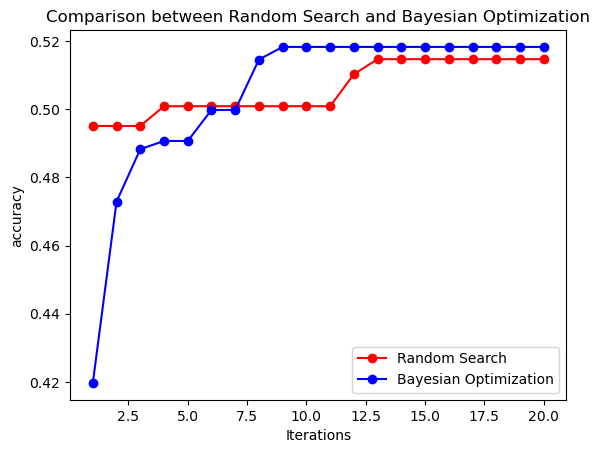

In [19]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO
y_bo = np.maximum.accumulate(-opt_bo.func_vals).ravel()
y_random = np.maximum.accumulate(-opt_random.func_vals).ravel()
# define iteration number
xs = range(1, len(y_bo) + 1)

plt.plot(xs, y_random, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

In [20]:
# get the max pariter

opt_bo.x_iters[np.argmax(-opt_bo.func_vals)]

print(opt_random)
print(opt_bo)

          fun: -0.5147
            x: [np.int64(240)]
    func_vals: [-4.951e-01 -4.464e-01 ... -3.117e-01 -4.778e-01]
      x_iters: [[np.int64(204)], [np.int64(48)], [np.int64(200)], [np.int64(153)], [np.int64(115)], [np.int64(26)], [np.int64(118)], [np.int64(86)], [np.int64(37)], [np.int64(167)], [np.int64(15)], [np.int64(185)], [np.int64(240)], [np.int64(1)], [np.int64(254)], [np.int64(158)], [np.int64(157)], [np.int64(3)], [np.int64(7)], [np.int64(135)]]
       models: []
        space: Space([Integer(low=1, high=256, prior='uniform', transform='normalize')])
 random_state: RandomState(MT19937)
        specs:     args:                    func: <function objective at 0x7f274562b6a0>
                                      dimensions: [Integer(low=1, high=256, prior='uniform', transform='normalize')]
                                  base_estimator: dummy
                                         n_calls: 20
                                 n_random_starts: None
                       